# PyFolding SI Notebook 6
---

[Author] ERGM

---

## This is to fit Equilibrium Curves to Heteropolymer Ising Model ##

In this notebook we will show how equilbrium folding data can be imported into a notebook and fitted to Heteropolymer Ising Model. 

If you are less script/computer orientated, you can simply change the data paths and other parameters for your proteins and re-run the jupyter notebook ( "Kernal/Restart & Run all" from the menu above).



## Data Format

Please see PyFolding SI Notebooks 1 and 2 for the format your data has to be in to enable this type of analysis.
Remember for Ising Model Analysis here each protein dataset (equilibrium denaturation curve) must have its own .csv

---

#### First off lets load pyfolding & pyplot into this ipython notebook (pyplot allows us to plot more complex figures of our results):

In [1]:
# use this command to tell Jupyter to plot figures inline with the text
%matplotlib inline

# import pyfolding, the pyfolding models and ising models
import pyfolding
from pyfolding import models, ising

# import the package for plotting, call it plt
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

PyFolding: Jupyter autoscrolling has been disabled


---

#### Now, we need to load some data to analyse.

I will import the equilibrium denaturation curves of a series of CTPRn variants proteins taken from:

```
Millership C., Phillips J.J. & Main E.R.G. (2016) “Ising model reprogramming of a repeat protein’s equilibrium unfolding pathway.” Journal of Molecular Biology, 428 (9A), 1804-1817.
```

I will load 12 denaturation curves (two repeats of each expt) that correspond to the following proteins:

Protein        |Filename              |No. of Helices |Truncation
:--------:     |:-------:             |:-------:      |:-------:
CTPR2$\Delta$A | CTPR2APhos1_10C.csv  |  4            |N-Terminal helix removed
CTPR2$\Delta$A | CTPR2APhos2_10C.csv  |  4            |N-Terminal helix removed
CTPR2$\Delta$S | CTPR2SPhos1_10C.csv  |  4            |C-Terminal helix removed
CTPR2$\Delta$S | CTPR2SPhos2_10C.csv  |  4            |C-Terminal helix removed
CTPR2          | CTPR2Phos1_10C.csv   |  5            |none
CTPR2          | CTPR2Phos1_10C.csv   |  5            |none
CTPR3$\Delta$A | CTPR3APhos1_10C.csv  |  6            |N-Terminal helix removed
CTPR3$\Delta$A | CTPR3APhos2_10C.csv  |  6            |N-Terminal helix removed
CTPR3$\Delta$S | CTPR3SPhos1_10C.csv  |  6            |C-Terminal helix removed
CTPR3$\Delta$S | CTPR3SPhos2_10C.csv  |  6            |C-Terminal helix removed
CTPR3          | CTPR3Phos1_10C.csv   |  7            |none
CTPR3          | CTPR3Phos1_10C.csv   |  7            |none


In [2]:
# start by loading a data set
# arguments are "path", "filename"
pth = "/Users/ergm/Dropbox/AlanLoweCollaboration/Datasets/EwanDatasets/Equilm/Ewan_CTPR_Datasets/Phos_pH7_10C" 
CTPR2A1 = pyfolding.read_equilibrium_data(pth,"CTPR2APhos1_10C.csv")
CTPR2A2 = pyfolding.read_equilibrium_data(pth,"CTPR2APhos2_10C.csv")
CTPR2S1= pyfolding.read_equilibrium_data(pth,"CTPR2SPhos1_10C.csv")
CTPR2S2 = pyfolding.read_equilibrium_data(pth,"CTPR2SPhos2_10C.csv")
CTPR2_1= pyfolding.read_equilibrium_data(pth,"CTPR2Phos1_10C.csv")
CTPR2_2 = pyfolding.read_equilibrium_data(pth,"CTPR2Phos2_10C.csv")
CTPR3A1 = pyfolding.read_equilibrium_data(pth,"CTPR3APhos1_10C.csv")
CTPR3A2 = pyfolding.read_equilibrium_data(pth,"CTPR3APhos2_10C.csv")
CTPR3S1 = pyfolding.read_equilibrium_data(pth,"CTPR3SPhos1_10C.csv")
CTPR3S2 = pyfolding.read_equilibrium_data(pth,"CTPR3SPhos2_10C.csv")
CTPR3_1 = pyfolding.read_equilibrium_data(pth,"CTPR3Phos1_10C.csv")
CTPR3_2 = pyfolding.read_equilibrium_data(pth,"CTPR3Phos2_10C.csv")

# make a python list of the data
curves = [CTPR2A1,CTPR2A2,CTPR2S1,CTPR2S2,CTPR2_1,CTPR2_2,CTPR3A1,CTPR3A2,CTPR3S1,CTPR3S2, CTPR3_1, CTPR3_2]

In [3]:
# set the temperature to 10 degrees C

pyfolding.set_temperature(10.0)

Set temperature to 10.00°C
(NOTE: Careful, this sets the temperature for all subsequent calculations)


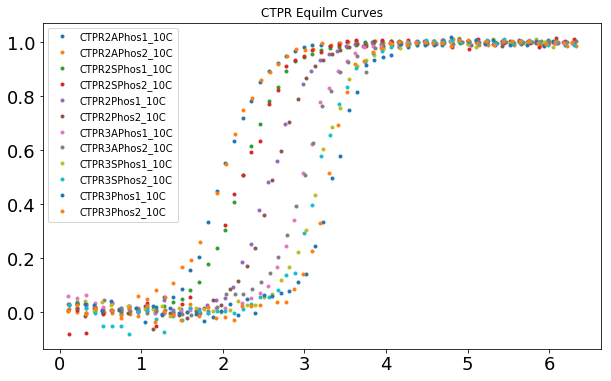

In [4]:
# Lets check everything was loaded correctly by plotting all the data curves on one plot

plt.figure(figsize=(10,6))
for c in curves:
    plt.plot(c.x, c.y, '.')

# the following commands plot all the data curves on one plot, where "loc" command determines where the legend goes.  
plt.legend([c.ID for c in curves], loc='best')
plt.title("CTPR Equilm Curves")
plt.show()


### Fitting to a Heteropolymer Ising model
We need to define a topology for each protein, this is essentially the domains of the protein in order (N->C)

#### Protein topology can be defined via the following Ising motifs

 Module              | Abbreviation | Defined in Ising as 
-----------------    | :----------: | --------------------
Module, type 1       | r            | RepeatDomain         
Module, type 2       | Mr           | MutantRepeatDomain   
Module, type 3       | h            | HelixDomain          
Module, type 4       | l            | LoopDomain           
Module, type 5       | Ml           | MutantLoopDomain       
Cap Module           | c            | CapDomain            
Mut. Cap Module      | Mc           | MutantCapDomain
Decoupled Cap Domain | DC           | DecoupleCapDomain

All modules functions are identical, except for the Decoupled Cap Domain and Cap domains. 
1. The Decoupled Cap domain has been coded such that the there is no interface energy between itself and any domain N-terminal to it.  
2. Cap domains are essentially identical to the other domains, except for clarity their interface energy term (G_ij) is not displayed when used in fitting. They should only be used at the C-terminus.

With regards to the other domains, you simply use them to define different modules present in your protein. The nomenclature stems from our various CTPR proteins analysis, as their repeated motifs can be defined in terms of either repeated TPRs, repeated helices and/or loops. 

##### Each motif is defined as having:
1. an intrinisic stability term for each module (Gi)
2. a denaturation dependence term (m_i) - which is associated with Gi
3. an interface energy term (G_ij) - defined as the interaction between folded units i and i+1, i.e. the interface of the i unit with the unit C terminal to it (i+1).
4. The Ising model automatically takes into account the C-terminal repeat does not have an interface term {ij} associated with it.

##### Except:
1. the Cap Motifs/Domains (Cap + Mutant Cap) do not print their interface term {ij} for clarity.
2. Thus the Cap domain should only be used when you have a C-terminal deletion.
3. The Decoupled Cap Domain do not use an interface term (hence "decoupled")

#####  Lets list the motifs already present in the Ising model to check that the above is correct!

In [5]:
# This command lists the motifs already present in the Ising model.
ising.list_models()

['CapDomain',
 'DecoupleCapDomain',
 'HelixDomain',
 'LoopDomain',
 'MutantCapDomain',
 'MutantLoopDomain',
 'MutantRepeatDomain',
 'RepeatDomain']

---
#### Lets define shorthand for Ising modules:

r = ising.RepeatDomain
Mr = ising.MutantRepeatDomain
c = ising.CapDomain
Mc = ising.MutantCapDomain
l = ising.LoopDomain
Ml = ising.MutantLoopDomain

#### With the CTPR dataset above we can code in the following example topologies:

Here the N and C terminii helices as defined as "caps" and the internal helices as the same:
A. topology1 = [[r,r,Mr,c], [l,r,r,r], [l,r,r,Mr,c], [r,r,r,r,Mr,c], [l,r,r,r,r,r], [l,r,r,r,r,Mr,c]]

Here A and B helices of each repeat are different, as are N and C terminii helices
B. topology2 = [[r,r,r,c], [l,r,r,r], [l,r,r,r,c], [r,r,r,r,r,c], [l,r,r,r,r,r], [l,r,r,r,r,r,c]]

Here A and B helices of each repeat are different, as are N and C terminii helices
C. topology3 = [[h,r,h,c], [r,h,r,h], [r,h,r,h,c], [h,r,h,r,h,c], [r,h,r,h,r,h], [r,h,r,h,r,h,c]]



Where the order of proteins is CTPR2-A, CTPR2-S, CTPR2, CTPR3-A, CTPR3-S, CTPR3 



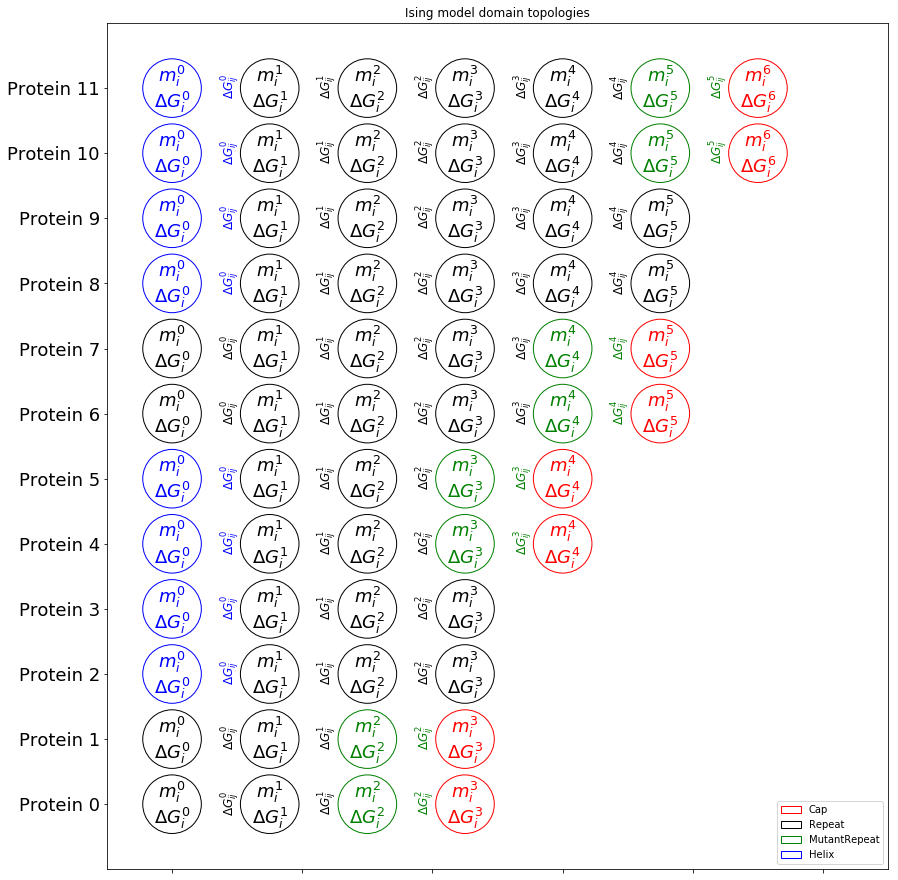

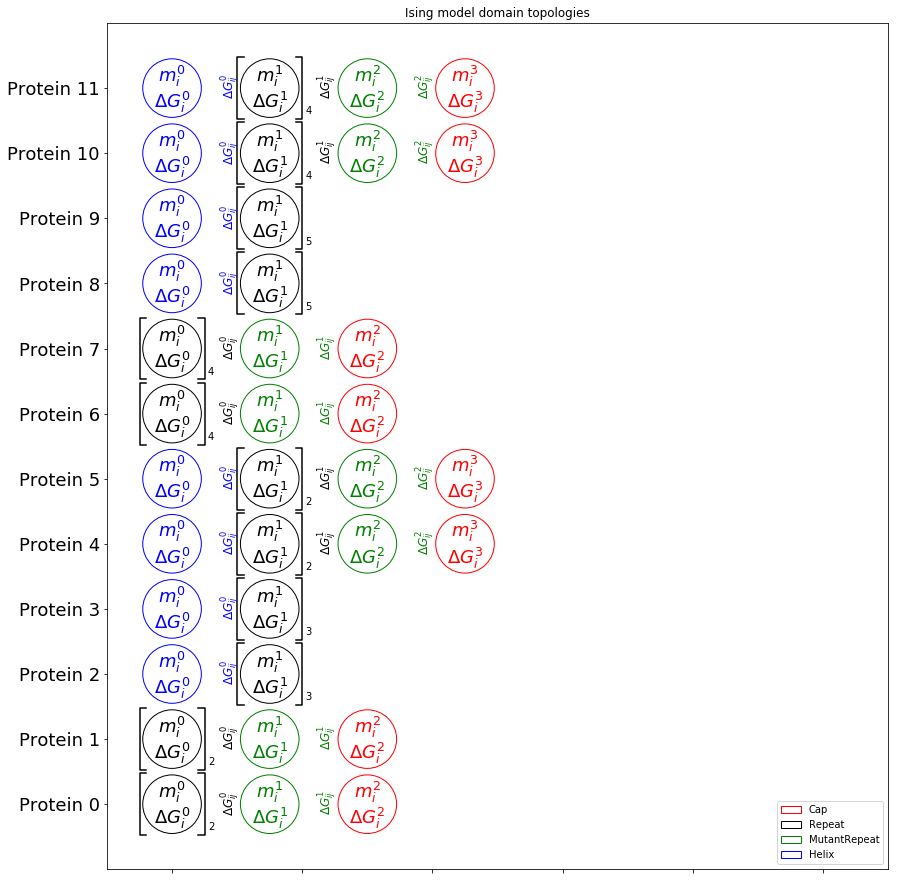

In [6]:
#Define shorthand for Ising modules:
r = ising.RepeatDomain
h = ising.HelixDomain
Mr = ising.MutantRepeatDomain
c = ising.CapDomain
Mc = ising.MutantCapDomain
l = ising.LoopDomain
Ml = ising.MutantLoopDomain

#lets try topology A first, but need to add in double as two curves of each protein
topology1 = [[r,r,Mr,c],[r,r,Mr,c], 
             [h,r,r,r], [h,r,r,r],
             [h,r,r,Mr,c], [h,r,r,Mr,c],
             [r,r,r,r,Mr,c], [r,r,r,r,Mr,c],
             [h,r,r,r,r,r],[h,r,r,r,r,r], 
             [h,r,r,r,r,Mr,c], [h,r,r,r,r,Mr,c]]

# plot them either in an expanded form
ising.plot_domains(topology1, collapse=False, save="/Users/ergm/Desktop/domain1.pdf")

# or in a collapsed form
ising.plot_domains(topology1, collapse=True, save="/Users/ergm/Desktop/domain2.pdf")

# NOTE: You can save the domain image by using the save keyword like this:
# ising.plot_domains([topology], collapse=True, save="/Users/ubcg83a/Desktop/domains.pdf")

Appending 12 curves to GlobalFitIsing...
 + added CTPR2APhos1_10C with topology ['Repeat', 'Repeat', 'MutantRepeat', 'Cap']
 + added CTPR2APhos2_10C with topology ['Repeat', 'Repeat', 'MutantRepeat', 'Cap']
 + added CTPR2SPhos1_10C with topology ['Helix', 'Repeat', 'Repeat', 'Repeat']
 + added CTPR2SPhos2_10C with topology ['Helix', 'Repeat', 'Repeat', 'Repeat']
 + added CTPR2Phos1_10C with topology ['Helix', 'Repeat', 'Repeat', 'MutantRepeat', 'Cap']
 + added CTPR2Phos2_10C with topology ['Helix', 'Repeat', 'Repeat', 'MutantRepeat', 'Cap']
 + added CTPR3APhos1_10C with topology ['Repeat', 'Repeat', 'Repeat', 'Repeat', 'MutantRepeat', 'Cap']
 + added CTPR3APhos2_10C with topology ['Repeat', 'Repeat', 'Repeat', 'Repeat', 'MutantRepeat', 'Cap']
 + added CTPR3SPhos1_10C with topology ['Helix', 'Repeat', 'Repeat', 'Repeat', 'Repeat', 'Repeat']
 + added CTPR3SPhos2_10C with topology ['Helix', 'Repeat', 'Repeat', 'Repeat', 'Repeat', 'Repeat']
 + added CTPR3Phos1_10C with topology ['Helix', '

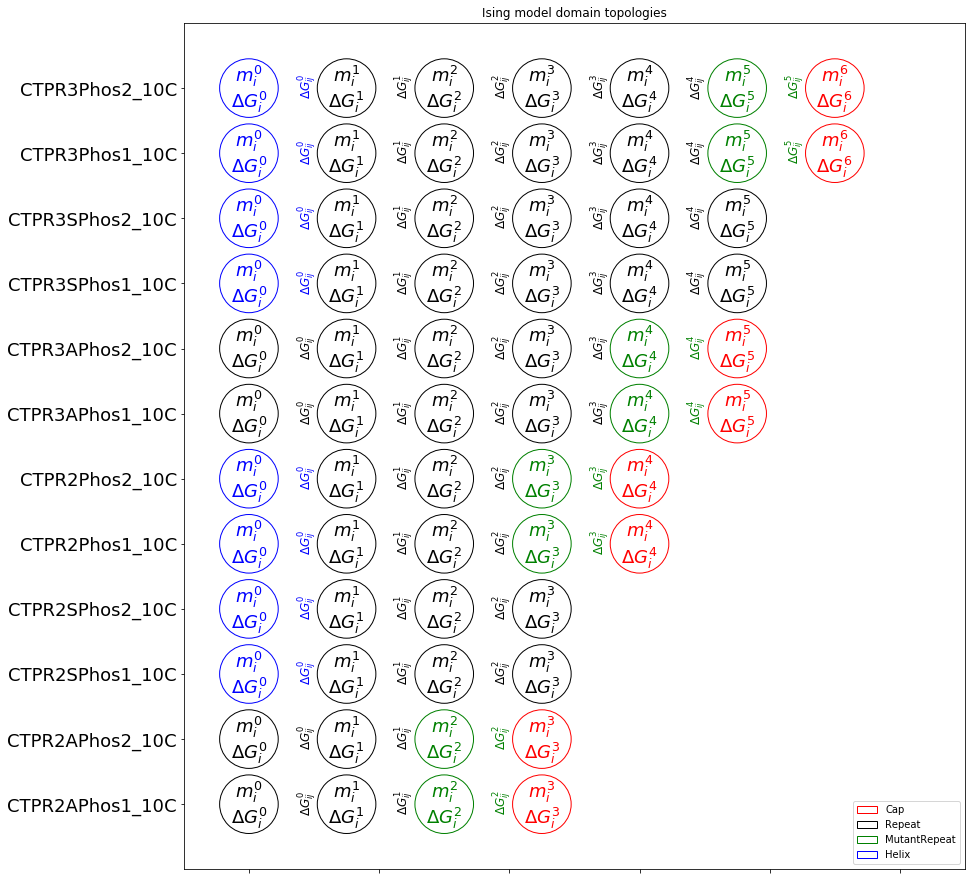

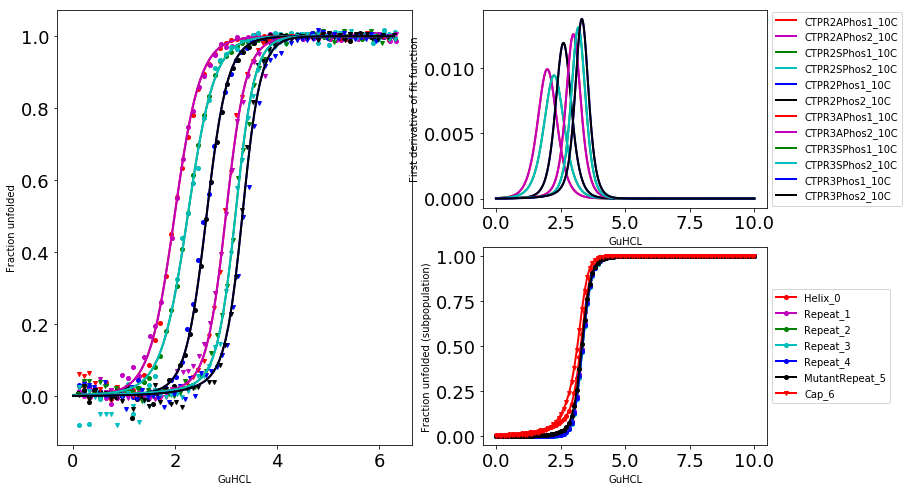

Written out .csv file of fits...


In [7]:
# note: popsize is the population size for the optimiser (bigger means more likelihood of reaching global optimum)
# start with a popsize of 10, increase to 100-1000 for better fits:
# curves defines the data you will fit, topologies define what it fits to
# ising.fit_heteropolymer(curves, topologies, popsize=10)

# for example, let's just fit the CTPRn datasets to topology 1:

ising.fit_heteropolymer(curves[0:12], topology1[0:12], popsize=10, maxiter= 10000, save="/Users/ergm/Desktop/FitResults")




Appending 12 curves to GlobalFitIsing...
 + added CTPR2APhos1_10C with topology ['Repeat', 'Repeat', 'Repeat', 'Cap']
 + added CTPR2APhos2_10C with topology ['Repeat', 'Repeat', 'Repeat', 'Cap']
 + added CTPR2SPhos1_10C with topology ['Helix', 'Repeat', 'Repeat', 'Repeat']
 + added CTPR2SPhos2_10C with topology ['Helix', 'Repeat', 'Repeat', 'Repeat']
 + added CTPR2Phos1_10C with topology ['Helix', 'Repeat', 'Repeat', 'Repeat', 'Cap']
 + added CTPR2Phos2_10C with topology ['Helix', 'Repeat', 'Repeat', 'Repeat', 'Cap']
 + added CTPR3APhos1_10C with topology ['Repeat', 'Repeat', 'Repeat', 'Repeat', 'Repeat', 'Cap']
 + added CTPR3APhos2_10C with topology ['Repeat', 'Repeat', 'Repeat', 'Repeat', 'Repeat', 'Cap']
 + added CTPR3SPhos1_10C with topology ['Helix', 'Repeat', 'Repeat', 'Repeat', 'Repeat', 'Repeat']
 + added CTPR3SPhos2_10C with topology ['Helix', 'Repeat', 'Repeat', 'Repeat', 'Repeat', 'Repeat']
 + added CTPR3Phos1_10C with topology ['Helix', 'Repeat', 'Repeat', 'Repeat', 'Repeat

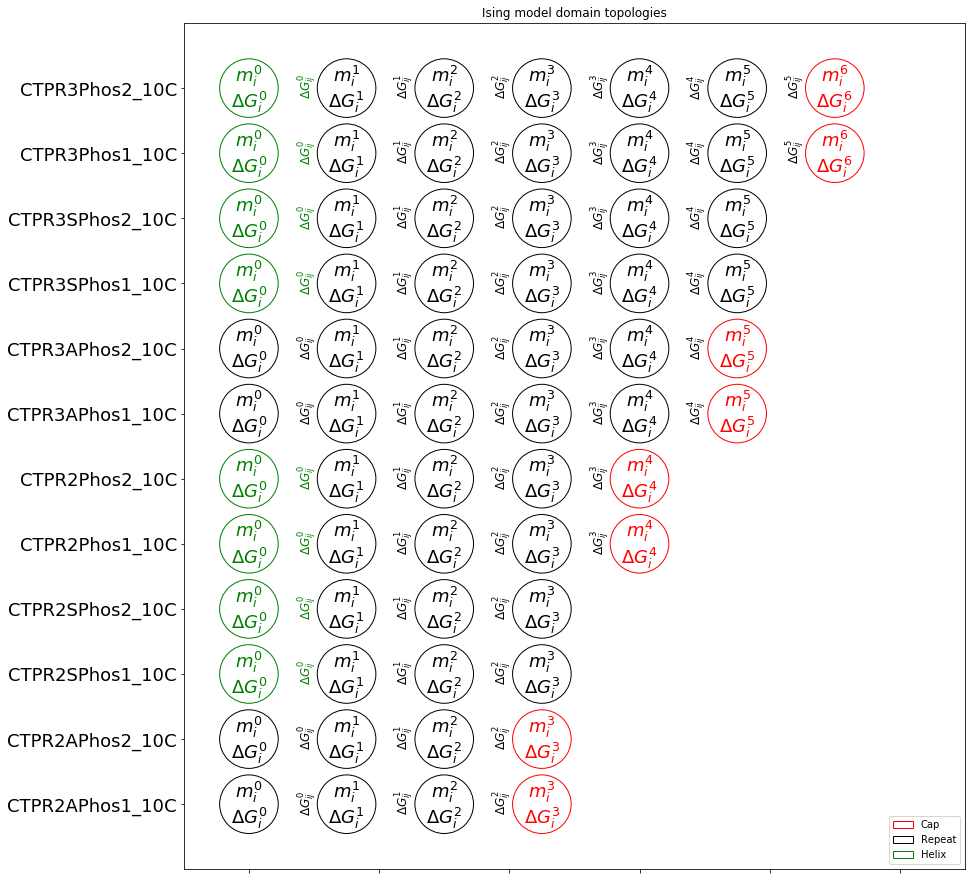

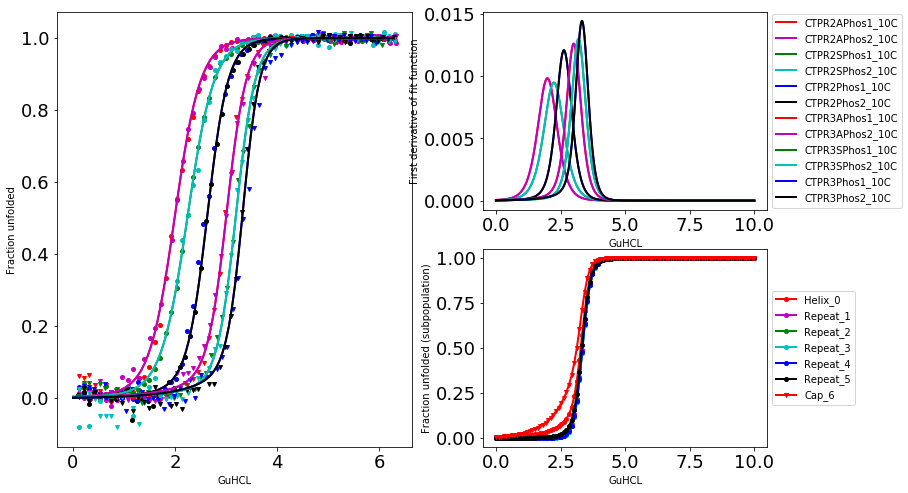

Written out .csv file of fits...


In [8]:
#Now do Topology 2
topology2 = [[r,r,r,c],[r,r,r,c], 
             [h,r,r,r], [h,r,r,r],
             [h,r,r,r,c], [h,r,r,r,c],
             [r,r,r,r,r,c], [r,r,r,r,r,c],
             [h,r,r,r,r,r],[h,r,r,r,r,r], 
             [h,r,r,r,r,r,c], [h,r,r,r,r,r,c]]

#Fit
ising.fit_heteropolymer(curves[0:12], topology2[0:12], popsize=10, maxiter= 10000, save="/Users/ergm/Desktop/FitResults")



Appending 12 curves to GlobalFitIsing...
 + added CTPR2APhos1_10C with topology ['Helix', 'Repeat', 'Helix', 'Cap']
 + added CTPR2APhos2_10C with topology ['Helix', 'Repeat', 'Helix', 'Cap']
 + added CTPR2SPhos1_10C with topology ['Repeat', 'Helix', 'Repeat', 'Helix']
 + added CTPR2SPhos2_10C with topology ['Repeat', 'Helix', 'Repeat', 'Helix']
 + added CTPR2Phos1_10C with topology ['Repeat', 'Helix', 'Repeat', 'Helix', 'Cap']
 + added CTPR2Phos2_10C with topology ['Repeat', 'Helix', 'Repeat', 'Helix', 'Cap']
 + added CTPR3APhos1_10C with topology ['Helix', 'Repeat', 'Helix', 'Repeat', 'Helix', 'Cap']
 + added CTPR3APhos2_10C with topology ['Helix', 'Repeat', 'Helix', 'Repeat', 'Helix', 'Cap']
 + added CTPR3SPhos1_10C with topology ['Repeat', 'Helix', 'Repeat', 'Helix', 'Repeat', 'Helix']
 + added CTPR3SPhos2_10C with topology ['Repeat', 'Helix', 'Repeat', 'Helix', 'Repeat', 'Helix']
 + added CTPR3Phos1_10C with topology ['Repeat', 'Helix', 'Repeat', 'Helix', 'Repeat', 'Helix', 'Cap']


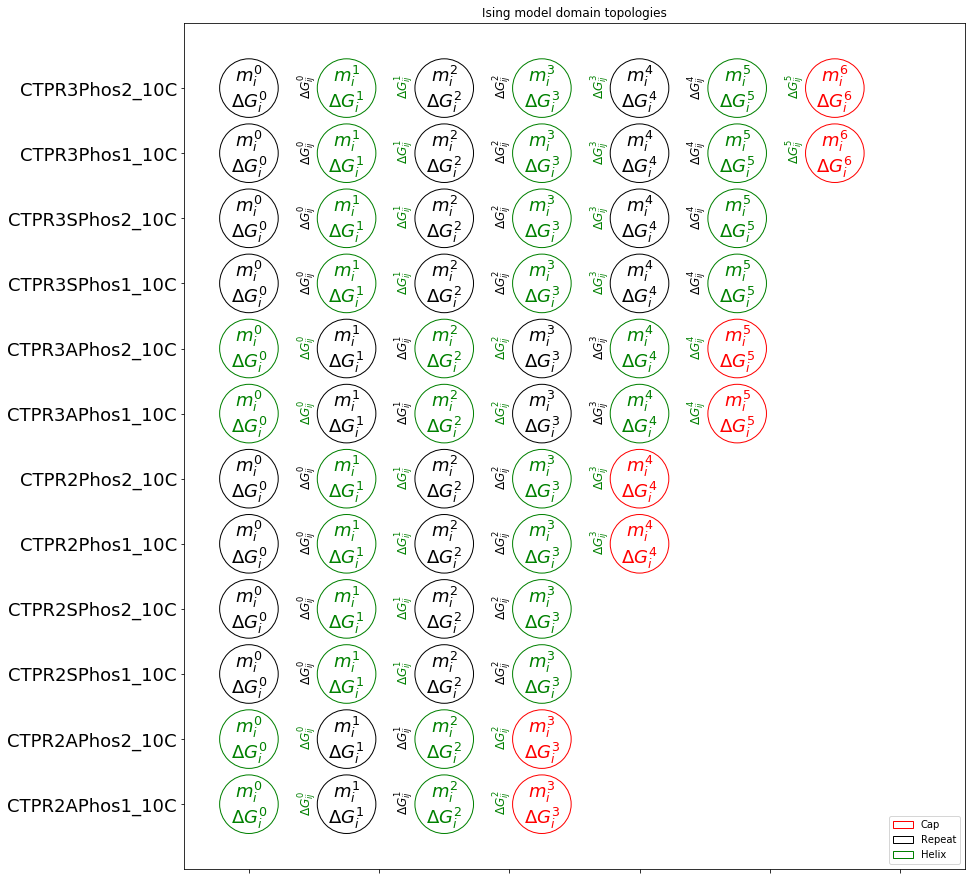

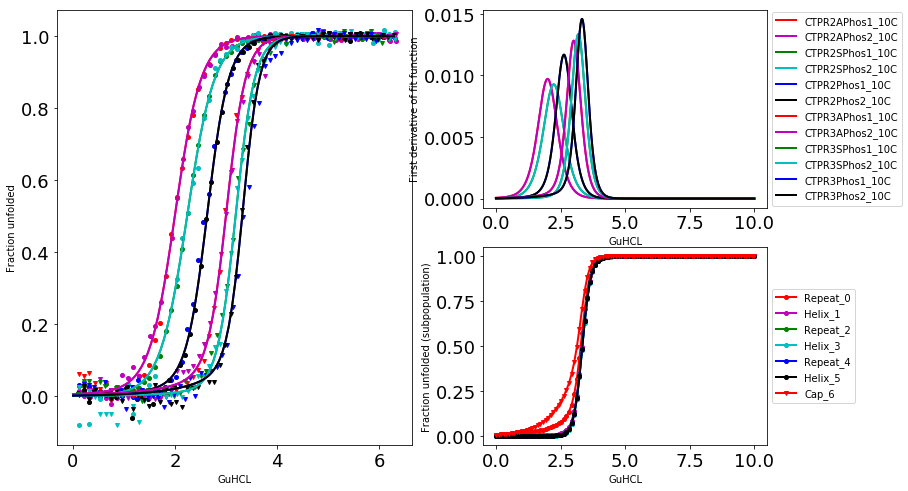

Written out .csv file of fits...


In [9]:
#Now do Topology 3
topology3 = [[h,r,h,c], [h,r,h,c],
              [r,h,r,h], [r,h,r,h],
              [r,h,r,h,c], [r,h,r,h,c],
              [h,r,h,r,h,c], [h,r,h,r,h,c],
              [r,h,r,h,r,h], [r,h,r,h,r,h],
              [r,h,r,h,r,h,c], [r,h,r,h,r,h,c]]

#fit
ising.fit_heteropolymer(curves[0:12], topology3[0:12], popsize=10, maxiter= 10000, 
                        save="/Users/ergm/Desktop/FitResults")

---

### End of this Notebook.

---